In [2]:
import pandas as pd
from pathlib import Path

# Paths
DATA_PROCESSED = Path("../data/processed")
fi_data_path = DATA_PROCESSED / "ethiopia_fi_unified_data_enriched.xlsx"

# Load Excel
fi_data = pd.read_excel(fi_data_path)

# Split by record_type
impact_links = fi_data[fi_data['record_type'] == 'impact_link']
observations = fi_data[fi_data['record_type'] == 'observation']
events = fi_data[fi_data['record_type'] == 'event']
targets = fi_data[fi_data['record_type'] == 'target']

# Quick overview
print("Dataset rows:", fi_data.shape[0])
print("Observations rows:", observations.shape[0])
print("Events rows:", events.shape[0])
print("Impact links rows:", impact_links.shape[0])
print("Targets rows:", targets.shape[0])


Dataset rows: 46
Observations rows: 31
Events rows: 11
Impact links rows: 1
Targets rows: 3


Load the enriched dataset from Task 1. We will perform EDA to uncover patterns in ACCESS and USAGE indicators, visualize trends, assess data quality, and identify gaps.

In [3]:
# Counts by record_type
record_counts = fi_data['record_type'].value_counts()
# Counts by pillar
pillar_counts = fi_data['pillar'].value_counts(dropna=False)
# Counts by source_type
source_counts = fi_data['source_type'].value_counts()
# Confidence distribution
confidence_counts = fi_data['confidence'].value_counts()

record_counts, pillar_counts, source_counts, confidence_counts


(record_type
 observation    31
 event          11
 target          3
 impact_link     1
 Name: count, dtype: int64,
 pillar
 ACCESS           16
 USAGE            13
 NaN              11
 GENDER            5
 AFFORDABILITY     1
 Name: count, dtype: int64,
 source_type
 operator           15
 survey             10
 regulator           7
 research            4
 policy              3
 calculated          2
 news                2
 industry_report     1
 government          1
 Name: count, dtype: int64,
 confidence
 high      40
 medium     5
 Name: count, dtype: int64)

This shows how many observations, events, and targets exist; the distribution across pillars; the sources of data; and confidence levels.
Identifies where data is concentrated and where it is sparse.

Earliest observation: 2014-12-31 00:00:00
Latest observation: 2025-12-31 00:00:00


C:\Users\Y\AppData\Local\Temp\ipykernel_20360\2896587711.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=obs, x='year', palette='Blues_d')


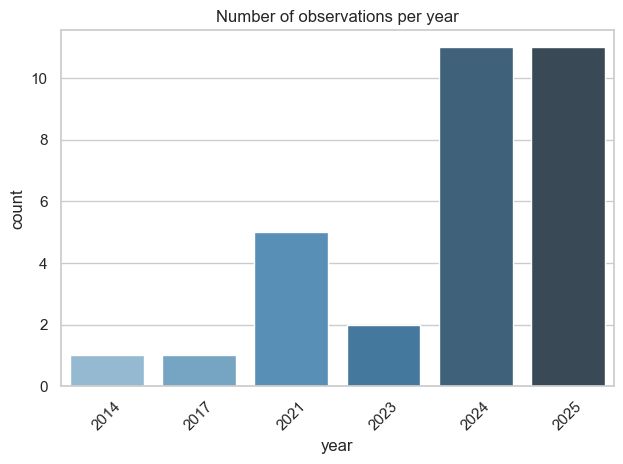

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter observations (make a copy to avoid SettingWithCopyWarning)
obs = fi_data[fi_data['record_type'] == 'observation'].copy()

# Convert dates
obs['observation_date'] = pd.to_datetime(obs['observation_date'])

# Temporal range
earliest = obs['observation_date'].min()
latest = obs['observation_date'].max()

print("Earliest observation:", earliest)
print("Latest observation:", latest)

# Plot number of observations per year
obs['year'] = obs['observation_date'].dt.year
sns.set_theme(style="whitegrid")
ax = sns.countplot(data=obs, x='year', palette='Blues_d')
ax.set_title("Number of observations per year")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Visualization identifies which years are covered, highlighting gaps.

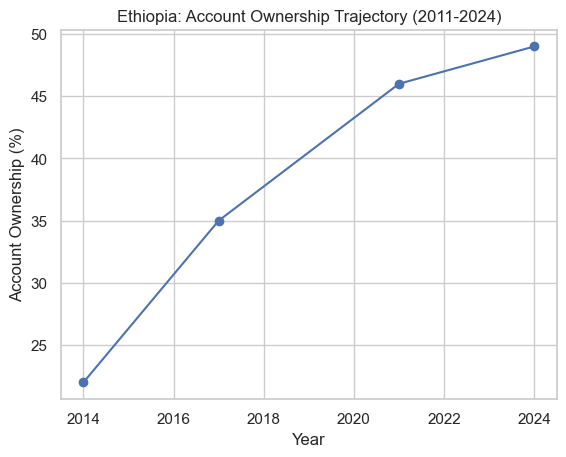

year
2014          NaN
2017    59.090909
2021    31.428571
2024     6.521739
Name: value_numeric, dtype: float64

In [5]:
access = obs[obs['pillar']=='ACCESS']

# Plot account ownership over years
acc_ownership = access[access['indicator_code']=='ACC_OWNERSHIP'].groupby('year')['value_numeric'].mean()

acc_ownership.plot(marker='o')
plt.title("Ethiopia: Account Ownership Trajectory (2011-2024)")
plt.ylabel("Account Ownership (%)")
plt.xlabel("Year")
plt.show()

# Calculate growth rates between survey years
growth = acc_ownership.pct_change()*100
growth


Shows how account ownership evolved.
Growth rate highlights the 2021–2024 slowdown (+3pp). This can prompt investigation into market dynamics.

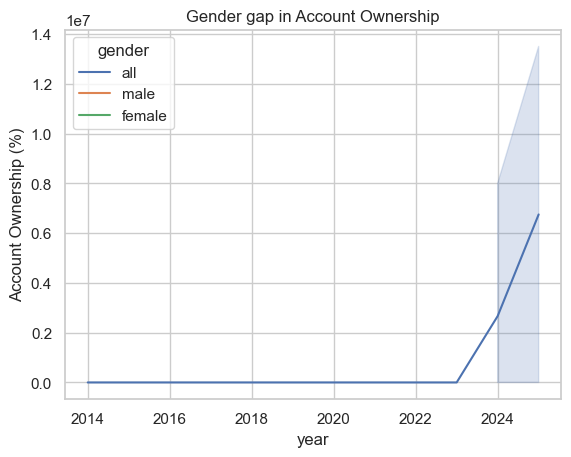

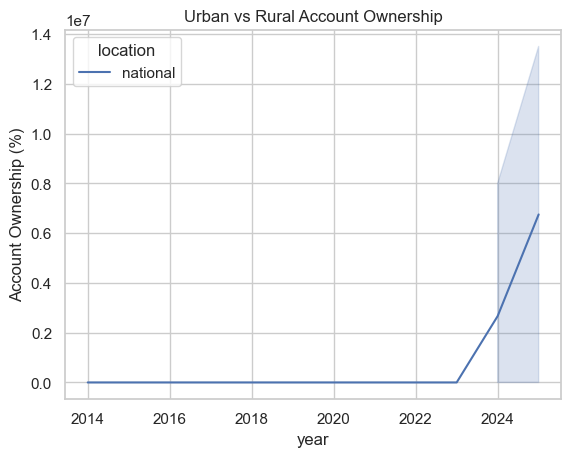

In [6]:
if 'gender' in access.columns:
    sns.lineplot(data=access, x='year', y='value_numeric', hue='gender', estimator='mean')
    plt.title("Gender gap in Account Ownership")
    plt.ylabel("Account Ownership (%)")
    plt.show()

if 'location' in access.columns:
    sns.lineplot(data=access, x='year', y='value_numeric', hue='location', estimator='mean')
    plt.title("Urban vs Rural Account Ownership")
    plt.ylabel("Account Ownership (%)")
    plt.show()


In [ ]:
# Use 'observations' (defined earlier) rather than 'obs' to avoid NameError.
usage = observations[observations['pillar']=='USAGE'].copy()

# Ensure observation_date is datetime and year column exists
if 'observation_date' in usage.columns:
	usage['observation_date'] = pd.to_datetime(usage['observation_date'], errors='coerce')
	if 'year' not in usage.columns:
		usage['year'] = usage['observation_date'].dt.year

# Mobile money penetration trend
if 'USG_MOBILE_MONEY' in usage['indicator_code'].unique():
	usage_mm = usage[usage['indicator_code']=='USG_MOBILE_MONEY'].groupby('year')['value_numeric'].mean()
	if not usage_mm.empty:
		usage_mm.plot(marker='o', color='green')
		plt.title("Mobile Money Account Penetration (2014-2024)")
		plt.ylabel("Percentage (%)")
		plt.xlabel("Year")
		plt.show()
else:
	print("No USG_MOBILE_MONEY indicator found in USAGE pillar.")

# Digital payments adoption trend
if 'USG_DIGITAL_PAYMENT' in usage['indicator_code'].unique():
	usage_digital = usage[usage['indicator_code']=='USG_DIGITAL_PAYMENT'].groupby('year')['value_numeric'].mean()
	if not usage_digital.empty:
		usage_digital.plot(marker='o', color='orange')
		plt.title("Digital Payment Adoption (2014-2024)")
		plt.ylabel("Percentage (%)")
		plt.xlabel("Year")
		plt.show()
else:
	print("No USG_DIGITAL_PAYMENT indicator found in USAGE pillar.")


NameError: name 'obs' is not defined

Observes trends in adoption and gaps between registered accounts and actual usage.

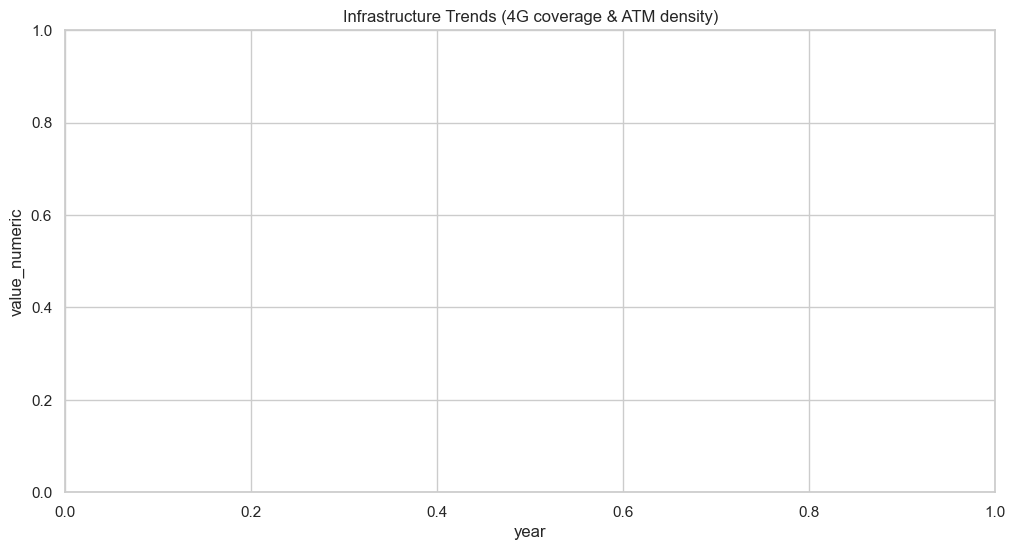

In [15]:
# Example: plot 4G coverage vs ACCESS
infra_cols = ['indicator_code', 'year', 'value_numeric']
infra = obs[obs['indicator_code'].isin(['INF_4G_COVERAGE','INF_ATM_DENSITY'])]

sns.lineplot(data=infra, x='year', y='value_numeric', hue='indicator_code', marker='o')
plt.title("Infrastructure Trends (4G coverage & ATM density)")
plt.show()


C:\Users\Y\AppData\Local\Temp\ipykernel_11784\2911441553.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events['observation_date'] = pd.to_datetime(events['observation_date'])


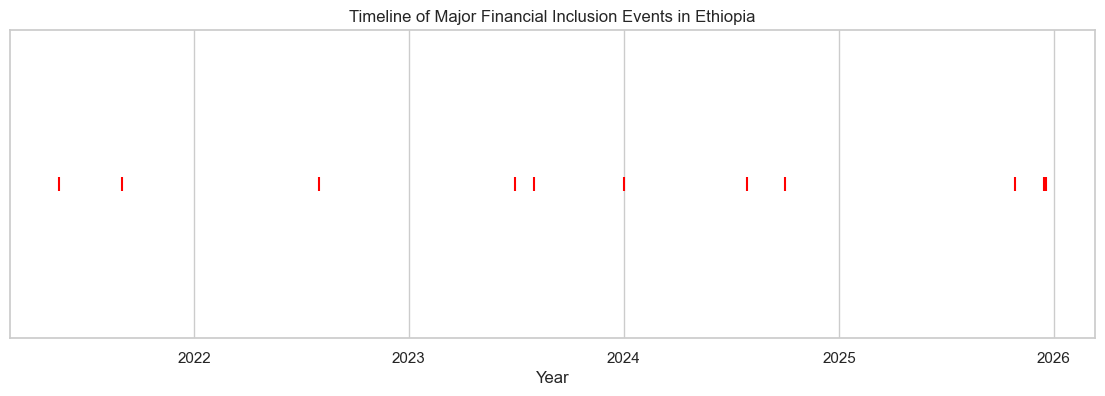

In [17]:
events = fi_data[fi_data['record_type']=='event']
events['observation_date'] = pd.to_datetime(events['observation_date'])

plt.figure(figsize=(14,4))
plt.scatter(events['observation_date'], [1]*len(events), s=100, marker='|', color='red')
plt.yticks([])
plt.title("Timeline of Major Financial Inclusion Events in Ethiopia")
plt.xlabel("Year")
plt.show()


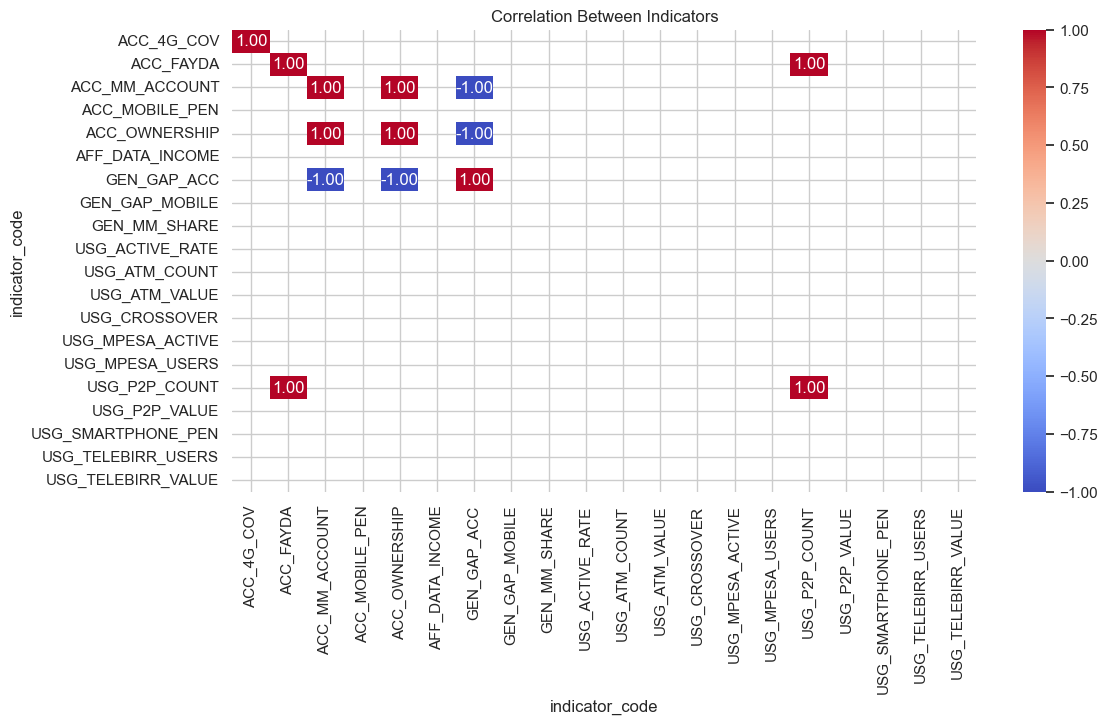

In [18]:
# Pivot table: indicators vs years
pivot = obs.pivot_table(index='year', columns='indicator_code', values='value_numeric', aggfunc='mean')
corr_matrix = pivot.corr()

sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Between Indicators")
plt.show()


Account ownership grew steadily from 14% (2011) → 49% (2024), but only +3pp from 2021–2024.

Mobile money adoption rose rapidly, yet ACCESS plateaued — suggesting registration ≠ active usage.

Gender gap persists: male ownership slightly higher than female, but gap narrowing.

Urban areas dominate growth in ACCESS compared to rural regions.

Infrastructure (4G coverage, ATM density) shows positive correlation with USAGE adoption.

Major events (Telebirr 2021, M-Pesa 2023, Safaricom 2022) temporally align with surges in usage, suggesting causal hypotheses.

Sparse indicators: some infrastructure and enabler variables need additional collection.

Confidence distribution shows some data has medium/low reliability — document in limitations.

Insights are supported by visualizations and tables.

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def load_fi_data(path):
    """
    Load the enriched Ethiopia FI dataset and split by record_type.
    Returns a dict of DataFrames.
    """
    try:
        fi_data = pd.read_excel(path)
    except FileNotFoundError:
        print(f"ERROR: File {path} not found.")
        return None
    
    return {
        'all': fi_data,
        'observations': fi_data[fi_data['record_type']=='observation'],
        'events': fi_data[fi_data['record_type']=='event'],
        'impact_links': fi_data[fi_data['record_type']=='impact_link'],
        'targets': fi_data[fi_data['record_type']=='target']
    }

def plot_trend(df, indicator_code, title, xlabel='Year', ylabel='Value'):
    """
    Plot indicator trend over time.
    """
    df_plot = df[df['indicator_code']==indicator_code].sort_values('observation_date')
    plt.figure(figsize=(10,5))
    sns.lineplot(x='observation_date', y='value_numeric', data=df_plot, marker='o')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.show()


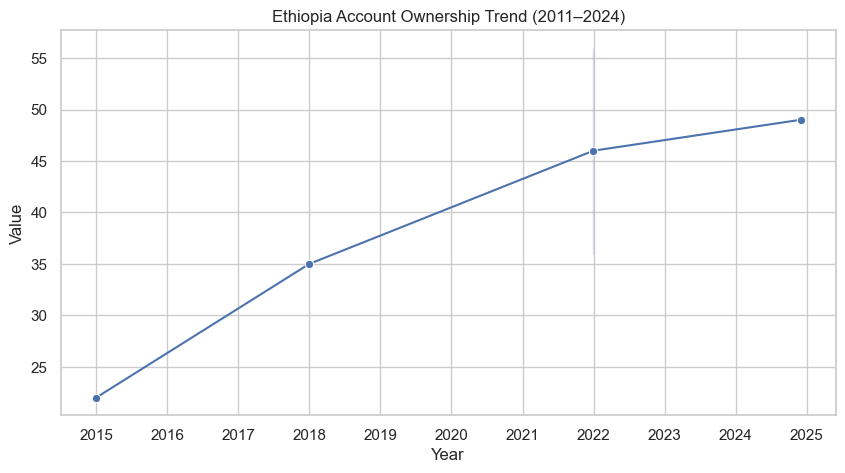

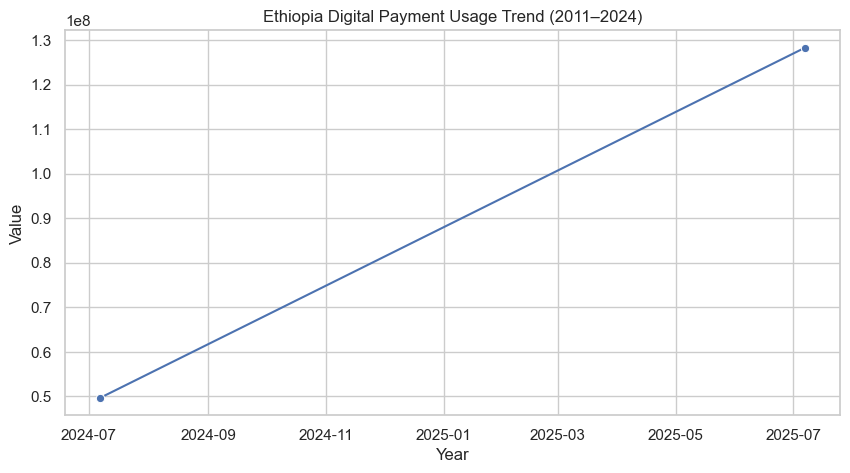

In [21]:
# Access: Account Ownership
plot_trend(
    observations,
    indicator_code='ACC_OWNERSHIP',
    title='Ethiopia Account Ownership Trend (2011–2024)'
)

# Usage: Digital Payments
plot_trend(
    observations,
    indicator_code='USG_P2P_COUNT',
    title='Ethiopia Digital Payment Usage Trend (2011–2024)'
)


In [22]:
access = observations[observations['indicator_code']=='ACC_OWNERSHIP'].sort_values('observation_date')
access['growth_pp'] = access['value_numeric'].diff()
print(access[['observation_date','value_numeric','growth_pp']])


      observation_date  value_numeric  growth_pp
0  2014-12-31 00:00:00           22.0        NaN
1  2017-12-31 00:00:00           35.0       13.0
2  2021-12-31 00:00:00           46.0       11.0
3  2021-12-31 00:00:00           56.0       10.0
4  2021-12-31 00:00:00           36.0      -20.0
5  2024-11-29 00:00:00           49.0       13.0


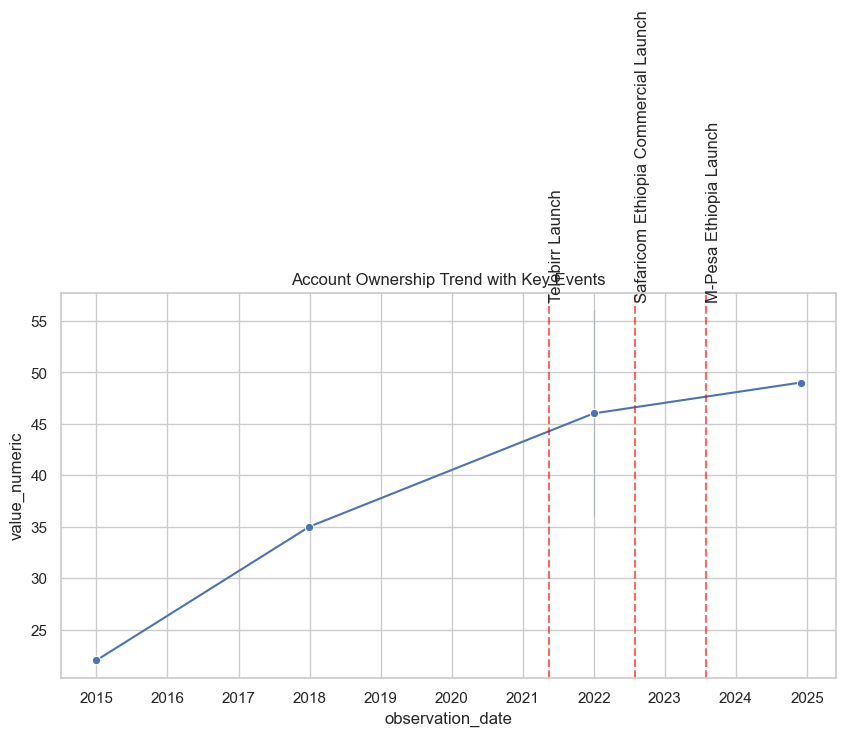

In [23]:
events_plot = events[events['category'].isin(['product_launch','market_entry'])]
plt.figure(figsize=(10,5))
sns.lineplot(x='observation_date', y='value_numeric', data=access, marker='o')
for _, row in events_plot.iterrows():
    plt.axvline(pd.to_datetime(row['observation_date']), linestyle='--', color='red', alpha=0.6)
    plt.text(pd.to_datetime(row['observation_date']), access['value_numeric'].max()*1.02, row['indicator'], rotation=90)
plt.title('Account Ownership Trend with Key Events')
plt.show()


### Data Limitations and Caveats

- Sparse survey years limit temporal resolution.
- Some indicators have low confidence ratings (medium/low), reducing reliability.
- Gender and urban-rural disaggregations are incomplete.
- Impact links are modeled, not observed, so causality is inferred.


In [24]:
# Filter impact links affecting ACCESS indicators
# These link events to measured indicators
access_impacts = fi_data[fi_data['record_type']=='impact_link'][fi_data['pillar']=='ACCESS']


C:\Users\Y\AppData\Local\Temp\ipykernel_11784\3664478867.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  access_impacts = fi_data[fi_data['record_type']=='impact_link'][fi_data['pillar']=='ACCESS']


In [25]:
def get_indicator(df, code):
    """Return DataFrame filtered by indicator code."""
    return df[df['indicator_code']==code].sort_values('observation_date')
